Imports Libraries

In [79]:
import pandas as pd
from IPython.display import display
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



Loads Data Frame

In [85]:
with open("ETHUSD_15min_tagged.pickle", \
          "rb") as f:
      df \
      = pickle.load(f)

df = df.drop(['Low','Close','High'], axis=1)
df
#df.drop(df.tail(1).index,inplace=True)

,Open,sma7,sma25,sma99,bb_bbm,bb_bbh,bb_bbl,psar,MACD,RSI,sma40,Position
0,1200.153076,1200.153076,1200.153076,1200.153076,0.000000,0.000000,0.000000,1204.813110,0.000000,100.000000,0.000000,1
1,1208.716797,1204.434937,1204.434937,1204.434937,0.000000,0.000000,0.000000,1214.011719,0.733792,100.000000,0.000000,1
2,1214.143066,1207.670980,1207.670980,1207.670980,0.000000,0.000000,0.000000,1204.813110,1.675682,100.000000,0.000000,1
3,1218.397949,1210.352722,1210.352722,1210.352722,0.000000,0.000000,0.000000,1213.272339,2.485572,100.000000,0.000000,1
4,1219.493652,1212.180908,1212.180908,1212.180908,0.000000,0.000000,0.000000,1213.272339,3.300964,100.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1429,1704.127686,1704.300868,1679.234526,1628.717507,1683.309027,1716.664803,1649.953251,1695.433201,14.764265,63.656235,1664.581348,1
1430,1707.095337,1705.221209,1681.275664,1629.592560,1685.309760,1719.325668,1651.293851,1697.978255,14.876273,65.405266,1665.991867,0
1431,1710.730835,1705.964024,1683.723604,1630.451497,1687.384265,1722.276544,1652.491986,1710.995605,13.957447,58.763115,1666.950128,0
1432,1700.739380,1704.872227,1685.762300,1631.194411,1688.425751,1723.605720,1653.245781,1710.995605,12.661342,55.725764,1668.294620,1


In [86]:
df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)



df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

X_train = df_train.drop('Position', axis=1)
X_valid = df_valid.drop('Position', axis=1)
y_train = df_train['Position']
y_valid = df_valid['Position']



Loads a model

In [87]:
model = tf.keras.models.load_model('Classifier_NN_hourly_v2.0')

# Check its architecture

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8)                 96        
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


Creates a Model

In [88]:

model = keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=[11]),
    layers.Dense(8, activation='relu'),    
    layers.Dense(1, activation='sigmoid'),
])

In [89]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

Trains a model

In [90]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=100,
    min_delta=0.001,
    restore_best_weights=True,
)



history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=2000,
    #callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)


In [91]:
score = model.evaluate(X_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.5982546806335449
Test accuracy: 0.6674418449401855


Best Validation Loss: 0.5959
Best Validation Accuracy: 0.6977


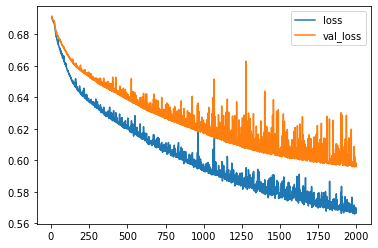

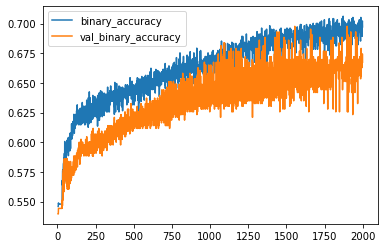

In [92]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [93]:
model.save('Classifier_15min_v1.0')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: Classifier_15min_v1.0/assets


/Users/esteban/miniforge3/envs/tf_m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Users/esteban/miniforge3/envs/tf_m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


In [94]:
import sklearn.naive_bayes
import sklearn.feature_extraction
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.metrics
import time
import sklearn.neighbors
import sklearn.ensemble
import sklearn.metrics
#pip install xgboost
import xgboost

In [95]:
# Creates a model

# Create naive bayes classifier
naive_bayes = sklearn.naive_bayes.MultinomialNB()

# Create a logistic regression classifier
logistic = sklearn.linear_model.LogisticRegression(solver='newton-cg',
                                                   tol=1e-2, max_iter=10000)

#Create a xgboost classifier
#xgboost = xgboost.XGBRFClassifier(alpha=1, max_depth=30)

# Create a k-Nearest neighbors classifier
kNN = sklearn.neighbors.KNeighborsClassifier(n_neighbors=150)

# Create a Random Forest classifier
randforest = sklearn.ensemble.RandomForestClassifier(n_estimators=1000,
    min_samples_leaf=0.003)


# Create a voting ensemble of classifiers
model = sklearn.ensemble.VotingClassifier(
    estimators=[('logistic', logistic),
                #('xgboost', xgboost),
                #('kNN', kNN),
                ('naive_bayes',naive_bayes),
                ('randforest', randforest),
                ],voting='soft')


# Train it with the training data and labels
model.fit(X_train, y_train)

# Predict
pred = model.predict(X_valid)


# Metrics
#

# Confusion matrix
cmatrix = sklearn.metrics.confusion_matrix(y_valid, pred)
print("Confusion Matrix:")
print(cmatrix)

# Accuracy, precision & recall
print("Accuracy:   {:.3f}".format(sklearn.metrics.accuracy_score(y_valid, pred)))
print("Precision:  {:.3f}".format(sklearn.metrics.precision_score(y_valid, pred, average='weighted')))
print("Recall:     {:.3f}".format(sklearn.metrics.recall_score(y_valid, pred, average='weighted')))



Confusion Matrix:
[[ 77 119]
 [ 40 194]]
Accuracy:   0.630
Precision:  0.637
Recall:     0.630
